In [1]:
# Library & Constants

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

# Paths

DATASET_DIR = './data'
MODEL_DIR = './models'


# Datsets Info

BENIGN_LABEL = ['Benign']
MALICIUS_LABELS = [
    'Web_XSS', 'Heartbleed', 'Web_SQL_Injection', 'DoS_Slowhttptest',
    'DoS_GoldenEye', 'Port_Scan', 'DDoS_LOIT', 'Botnet_ARES', 'Web_Brute_Force',
    'SSH-Patator', 'FTP-Patator', 'DoS_Hulk', 'DoS_Slowloris'
]
LABELS = BENIGN_LABEL + MALICIUS_LABELS


# Dataset
Prima di procedere con la modellazione del dataset e alla creazione del modello, procediamo con il capire come i dati sono strutturati, cosa rappresentano e quali modifiche rapportare.

In [2]:
# Load Data

def load_data(datasets_dir: str) -> pd.DataFrame:
    """
    Load all datasets from a directory into a single DataFrame

    :param str datasets_dir: directory containing the datasets
    :return: pd.DataFrame containing all datasets
    """

    data = []
    for file in os.listdir(datasets_dir):
        if file.endswith('.csv'):
            data.append(pd.read_csv(os.path.join(datasets_dir, file)))
    return pd.concat(data, ignore_index=True)


dataset = load_data(DATASET_DIR)

## Data Exploration

Iniziamo l’analisi osservando la quantità di dati disponibili nel nostro dataset, BCCC-CIC-IDS2017, che comprende un totale impressionante di 2.438.052 record. Questi dati sono stati generati utilizzando NTLFlowLyzer, in contrasto con la versione precedente del dataset (CIC-IDS2017), che aveva invece adottato lo strumento CICFlowMeter per l'estrazione.

Per approfondire e comprendere meglio i dati a disposizione, esploriamoli graficamente per analizzarne la distribuzione e identificarne eventuali pattern significativi.

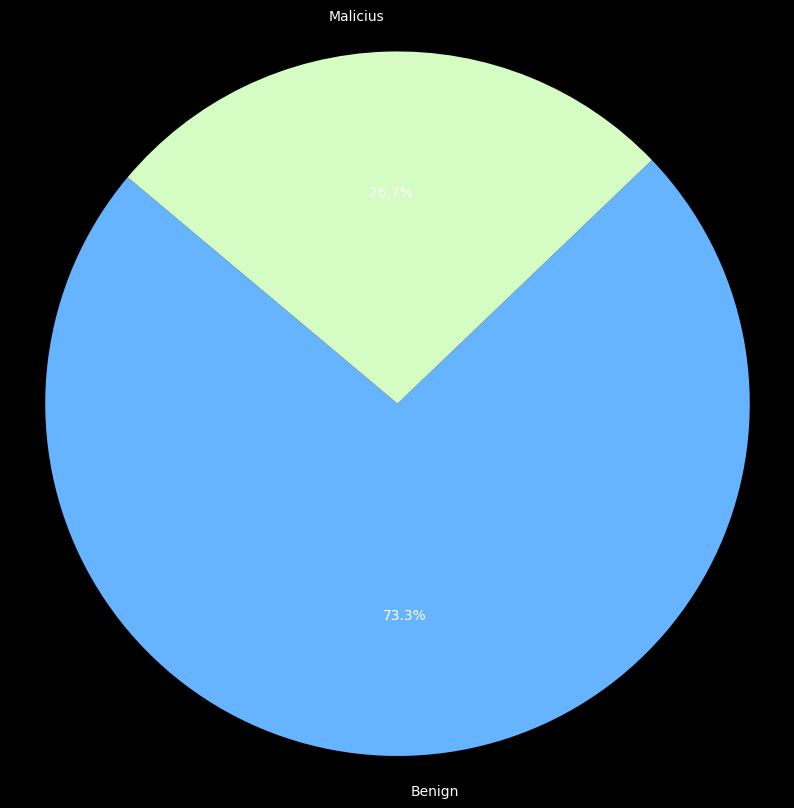

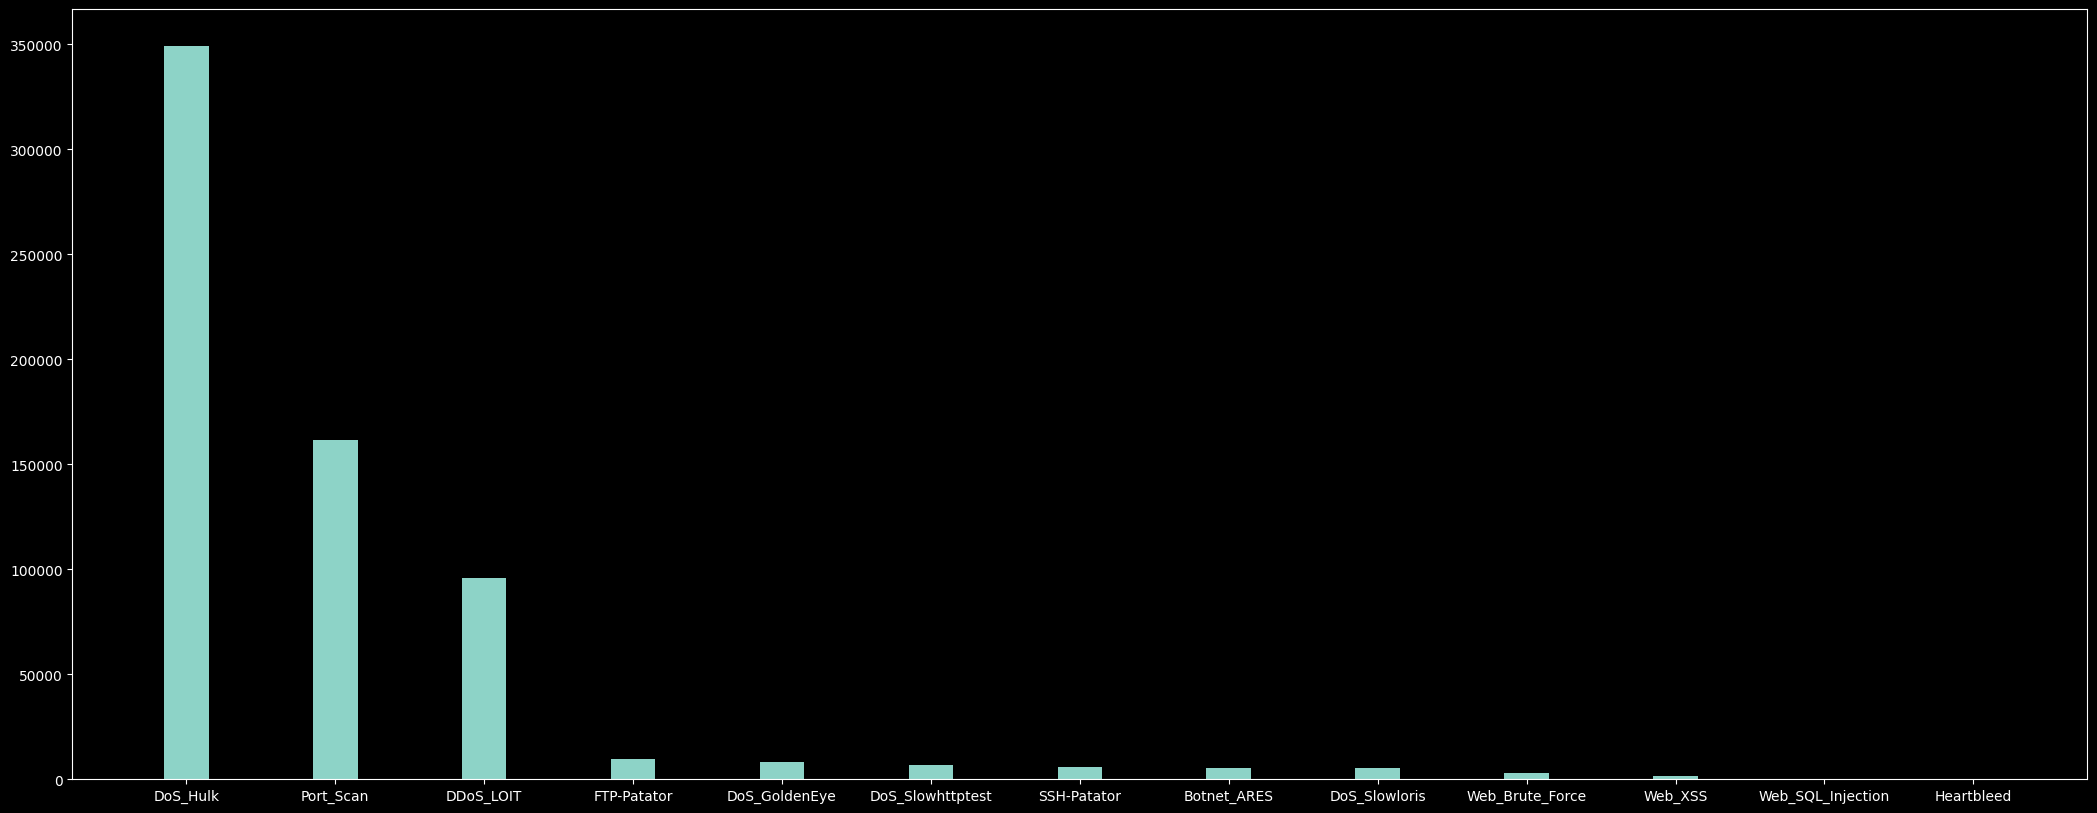

In [3]:
# Plot Data

def plot_attack_distribution(dataset: pd.DataFrame):
    """
    Generates a bar chart to visualize the distribution of attack labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    """

    with plt.style.context('dark_background'):
        attack_data = dataset[dataset['label'].isin(MALICIUS_LABELS)]['label'].value_counts()
        
        fig, ax = plt.subplots(figsize=(26, 10))
        ax.bar(attack_data.index, attack_data.values, width=0.3)
    

def plot_distribution(dataset: pd.DataFrame):
    """
    Generates a pie chart to visualize the distribution of 'Benign' and 'Attack' labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    """

    with plt.style.context('dark_background'):
        data = {
            'Benign': dataset['label'].isin(BENIGN_LABEL).sum(),
            'Malicius': dataset['label'].isin(MALICIUS_LABELS).sum()
        }
        plt.figure(figsize=(10, 10))
        plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#D4FCC3'])
        plt.axis('equal')
        plt.show()


plot_distribution(dataset)
plot_attack_distribution(dataset)

Dall'analisi dei dati emergono due osservazioni principali:
1. Il traffico normale è significativamente più rappresentato rispetto al traffico malevolo. Questo squilibrio può essere affrontato in modo intuitivo attraverso l’applicazione di tecniche di __undersampling__ sui dati relativi al traffico normale.
2. La distribuzione dei dati degli attacchi non è uniforme.

Concentrandoci sul secondo punto, l’alto sbilanciamento dei dati può influire negativamente sulle prestazioni del modello, aumentando il rischio di errori di predizione, soprattutto per le classi meno rappresentate. Per mitigare questo problema, è possibile adottare diversi approcci, ognuno con vantaggi e svantaggi:

- Escludere attacchi con pochi dati
- Applicare tecniche di undersampling e oversampling(undersampling).
- Focalizzarsi su un singolo tipo di attacco


_Per semplicità, procediamo con l'under sampling ed escludiamo il problema della distribuzione degli attacchi etichettando i dati solo con "Benign" e "Malicious"_

## Data Preparation

In [4]:
# Data Cleaning
from typing import List

def clean_data(dataset: pd.DataFrame, columns_to_remove: List[str]) -> pd.DataFrame:
    """
    Cleans the given dataset.

    :param pd.DataFrame dataset: The dataset to clean.
    :param List[str] columns_to_remove: The columns to remove from the dataset.
    :return: The cleaned dataset.
    """

    dataset = dataset.dropna()
    dataset = dataset.drop_duplicates()

    float_cols = dataset.select_dtypes(include=['float']).columns
    dataset[float_cols] = dataset[float_cols].round(4)

    dataset = dataset.drop(columns=columns_to_remove)

    return dataset


columns_to_remove = ["flow_id", "src_ip", "dst_ip", "src_port", "timestamp"]
dataset = clean_data(dataset, columns_to_remove)

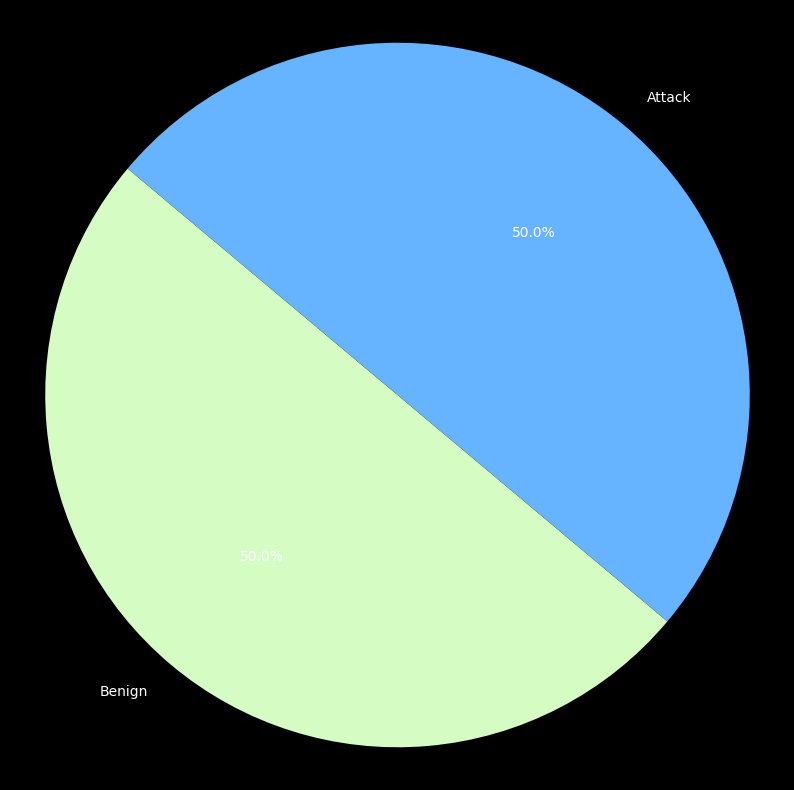

In [5]:
# Data Preprocessing

def binary_labelling(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the 'label' column in the given dataset to binary labels.

    :param pd.DataFrame dataset: The dataset to convert.
    :return: The dataset with binary labels.
    """

    dataset['label'] = dataset['label'].apply(lambda x: 0 if x in BENIGN_LABEL else 1)
    return dataset


def undersampling(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Undersamples the given dataset to balance the number of benign and attack samples.

    :param pd.DataFrame dataset: The dataset to undersample.
    :return: The undersampled dataset.
    """

    benign = dataset[dataset['label'] == 0]
    attack = dataset[dataset['label'] == 1]

    benign_downsampled = resample(benign, replace=False, n_samples=len(attack), random_state=42)
    return pd.concat([benign_downsampled, attack])


def one_hot_encoding(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    One-hot encodes the 'protocol' column in the given dataset.

    :param pd.DataFrame dataset: The dataset to one-hot encode.
    :return: The dataset with one-hot encoded 'protocol' column.
    """

    return pd.get_dummies(dataset, columns=['protocol'])


def normalize_data(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Normalizes the given dataset using Min-Max scaling.

    :param pd.DataFrame dataset: The dataset to normalize.
    :return: The normalized dataset.
    """

    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)


dataset = binary_labelling(dataset)
dataset = undersampling(dataset)
dataset = one_hot_encoding(dataset)

with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 10))
    plt.pie(dataset['label'].value_counts(), labels=['Benign', 'Attack'], autopct='%1.1f%%', startangle=140, colors=['#D4FCC3', '#66b3ff'])
    plt.axis('equal')
    plt.show()

In [6]:
# Feature Selection

from typing import Tuple

def extract_feature_and_target(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Extracts the feature and target columns from the given dataset.

    :param pd.DataFrame dataset: The dataset to extract the feature and target columns from.
    :return: The feature and target columns.
    """

    return dataset.drop(columns=['label']), dataset['label']


def select_features(dataset: pd.DataFrame, target: pd.Series, threshold: float = 0.01, xgb: bool = True) -> pd.DataFrame:
    """
    Selects the most important features from the given dataset using an XGBoost classifier.

    :param pd.DataFrame dataset: The dataset to select features from.
    :param pd.Series target: The target column.
    :param float threshold: The threshold to select features.
    :param bool xgb: Whether to use an XGBoost classifier or RandomForest.
    :return: The selected features.
    """

    if xgb:
        clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    else:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(dataset, target)

    feature_importances = pd.Series(clf.feature_importances_, index=dataset.columns).sort_values(ascending=False)
    
    sfm = SelectFromModel(clf, threshold=threshold, prefit=True)

    return dataset.columns[sfm.get_support()]


x, y = extract_feature_and_target(dataset)
features = select_features(x, y)

print(f"Selected features with threshold >= 0.01:")
for feature in features:
    print(feature)

X = dataset[features]


/home/suga/Desktop/IDS-AI/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:43:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features with threshold >= 0.01:
duration
payload_bytes_std
bwd_payload_bytes_variance
min_header_bytes
mean_header_bytes
psh_flag_counts
rst_flag_counts
bwd_fin_flag_counts
bwd_psh_flag_counts


# Modelling
Procederemo con lo sviluppo del modello facendo riferimento progetto github (_"Efficient-CNN-BiLSTMs"_)[https://github.com/jayxsinha/Efficient-CNN-BiLSTM-for-Network-IDS/] per la sua struttura

In [7]:
# Data Splitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Model Design
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Bidirectional, LSTM, Reshape, Dropout, Dense, Activation

def build_model(input_shape=(122, 1)):
    model = Sequential()
    
    # 1D Convolutional layer
    model.add(Convolution1D(64, kernel_size=122, padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5))
    model.add(BatchNormalization())
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    
    # Reshape layer
    model.add(Reshape((128, 1), input_shape=(128,)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(BatchNormalization())
    
    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    
    # Dropout layer
    model.add(Dropout(0.5))
    
    # Dense output layer with sigmoid activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = build_model(input_shape=(len(features), 1))

2024-12-06 18:43:49.500856: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 18:43:49.548303: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 18:43:49.597334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733507029.652063  177434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733507029.667371  177434 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 18:43:49.791812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [9]:
# Model Training

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

def train_model(model, X_train, y_train, batch_size=32, epochs=10, validation_data=None):
    """
    Trains the given model.

    :param keras.models.Sequential model: The model to train.
    :param np.ndarray X_train: The training features.
    :param np.ndarray y_train: The training target.
    :param int batch_size: The batch size for training.
    :param int epochs: The number of epochs for training.
    :param Tuple[np.ndarray, np.ndarray] validation_data: The validation features and target.
    :return: The trained model and training history.
    """

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data
    )
    return model, history


model, history = train_model(model, X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 624s 19ms/step - accuracy: 0.9156 - loss: 0.2456 - val_accuracy: 0.9309 - val_loss: 0.1874
Epoch 2/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 619s 19ms/step - accuracy: 0.9339 - loss: 0.1858 - val_accuracy: 0.8388 - val_loss: 0.4375
Epoch 3/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 620s 19ms/step - accuracy: 0.9186 - loss: 0.2124 - val_accuracy: 0.9388 - val_loss: 0.1731
Epoch 4/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 621s 19ms/step - accuracy: 0.9146 - loss: 0.2144 - val_accuracy: 0.9401 - val_loss: 0.1783
Epoch 5/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 620s 19ms/step - accuracy: 0.9338 - loss: 0.1951 - val_accuracy: 0.9393 - val_loss: 0.1795
Epoch 6/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 620s 19ms/step - accuracy: 0.8821 - loss: 0.2640 - val_accuracy: 0.9400 - val_loss: 0.1761
Epoch 7/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 620s 19ms/step - accuracy: 0.9104 - loss: 0.2254 - val_accuracy: 0.9366 - val_loss: 0.1750
Epoch 8/10
32499/32499 ━━━━━━━━━━━━━━━━━━━━ 620s 19ms/s

8125/8125 ━━━━━━━━━━━━━━━━━━━━ 73s 9ms/step


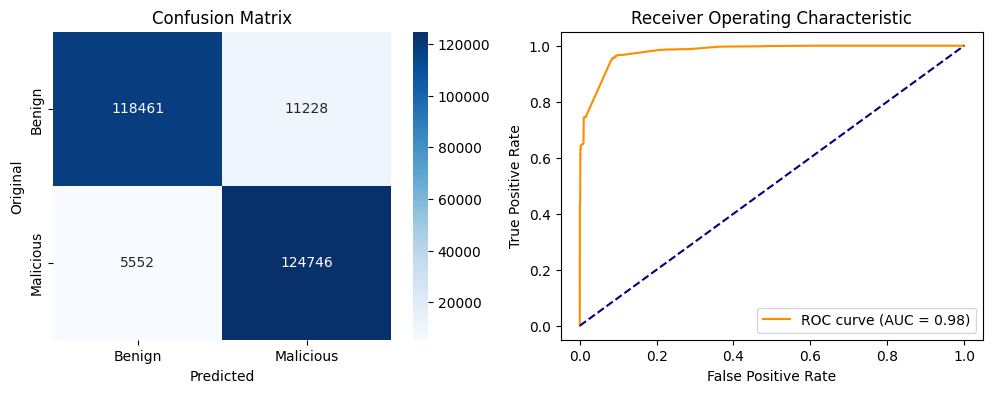

Accuracy: 0.94
F1 Score: 0.94


In [10]:
# Model Evaluation
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score
import seaborn as sns

def evaluate_model(model, X_test, y_test) -> plt.Figure:
    y_pred_probs = model.predict(X_test).ravel()
    y_pred = (y_pred_probs >= 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 4))
    labels = ["Benign", "Malicious"]

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Original")
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")

    plot = plt.gcf()

    return plot


plot_cm_and_roc = evaluate_model(model, X_test, y_test)

In [11]:
# Save Model

def save_model(model, plot: plt.Figure, path: str = MODEL_DIR):
    """
    Saves the given model to the specified path.

    :param keras.models.Sequential model: The model to save.
    :param plt.Figure plot: The plot to save.
    :param str path: The path to save the model to.
    """
    
    if not os.path.exists(path):
        os.makedirs(path)

    version = len(os.listdir(path)) + 1
    model_dir = os.path.join(path, f"v{version}")

    os.makedirs(model_dir)

    model.save(os.path.join(model_dir, "model.keras"))
    plot.savefig(os.path.join(model_dir, "cm_and_roc.png"))


save_model(model, plot_cm_and_roc)
